# Analysing SSN fits with differing ADF flags
Sam Hollenbach, Andrés Muñoz-Jaramillo

# Modules, colors, and functions

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
#import seaborn as sns
from copy import deepcopy

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath
from detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 21}

plt.rc('font', **font)

# Histogram and scatter plot
def plotHistSqrtSSN(ax, calRefT, calObsT, maxN):

    # Number of bins to use
    Nbins = np.sqrt(calRefT.shape[0])/5
    Nbins = 15
    
    
    calRefT = np.sqrt(calRefT+1)
    calObsT = np.sqrt(calObsT+1)
    
    #Edges and Centers
    edges = np.arange(1,np.ceil(maxN), (np.ceil(maxN))/Nbins)
    centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2
    
    # Average group number 
    ax.hist2d(calObsT, calRefT, bins=edges, cmap=plt.cm.magma_r,cmin=1)
    
    # Calculating Quantities for plot
    hist, xedges, yedges = np.histogram2d(calObsT, calRefT, bins=edges)
    xx, yy = np.meshgrid(centers, centers)

    meanY = np.divide(np.sum(np.multiply(hist,xx),axis=1),np.sum(hist,axis=1))
    alphaY = np.sum(hist,axis=1)/np.max(np.sum(hist,axis=1))*0.95+0.05
    
    meanX = np.divide(np.sum(np.multiply(hist,yy),axis=0),np.sum(hist,axis=0))
    alphaX = np.sum(hist,axis=0)/np.max(np.sum(hist,axis=0))*0.95+0.05     
    
    mx, my = np.meshgrid(meanY, meanY)
    
    sDY = np.divide(np.sum(np.multiply(hist,np.power(xx-my,2)),axis=1),np.sum(hist,axis=1))
    
    # Calculating quantities for assessment
    y = meanY
    x = centers
    
    x = x[np.isfinite(y)]
    y = y[np.isfinite(y)]
    

    
    # R squared
    yMean = np.mean(y)    
    SStot = np.sum(np.power(y-yMean,2)) 
    SSreg = np.sum(np.power(y-x,2))
    rSq   = (1 - SSreg/SStot)*sp.stats.pearsonr(x,y)[0]
    
    # Mean Residual
    mRes = np.mean(y-x)
    
    print(meanY)
    print(sDY)
    
    # Plot centers in Y
    for i in range(0, meanY.shape[0]):
        ax.errorbar(centers[i], meanY[i], sDY[i], color='k', zorder=11, alpha=alphaY[i])
        ax.scatter(centers[i], meanY[i], color='w', edgecolor='k', s=100, linewidths = 3, zorder=11, alpha=alphaY[i])

        
    # for i in range(0, meanY.shape[0]):
    #     ax.scatter(meanX[i], centers[i],  color='b', edgecolor='b', s=50, linewidths = 3, zorder=11, alpha=alphaY[i])

    ax.plot(edges, edges, '--'
             , color = Clr[4], linewidth = 3)

    ax.text(0.5, 0.95,'$PCCR$=' + str(np.round(rSq,decimals=2)) + '  MR=' + str(np.round(mRes,decimals=2)), horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)


# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

# Reading CSV Data
Read CSV file for each flag


In [245]:
dat_AM = pd.read_csv('out/A_M_Observer_ADF.csv', quotechar = '"', encoding = 'utf-8',header = 0)
dat_AM = dat_AM[np.isfinite(dat_AM['R2'])]
dat_QM = pd.read_csv('out/Q_M_Observer_ADF.csv', quotechar = '"', encoding = 'utf-8',header = 0)
dat_QM = dat_QM[np.isfinite(dat_QM['R2'])]
dat_AO = pd.read_csv('out/A_O_Observer_ADF.csv', quotechar = '"', encoding = 'utf-8',header = 0)
dat_AO = dat_AO[np.isfinite(dat_AO['R2'])]
dat_QO = pd.read_csv('out/Q_O_Observer_ADF.csv', quotechar = '"', encoding = 'utf-8',header = 0)
dat_QO = dat_QO[np.isfinite(dat_QO['R2'])]
print(dat_AM.columns.values)
#print(dat_AM)

['Observer' 'Station' 'AvThreshold' 'SDThreshold' 'R2' 'Avg.Res'
 'AvThresholdS' 'SDThresholdS' 'R2S' 'Avg.Res.S' 'R2DT' 'Avg.ResDT' 'R2OO'
 'Avg.ResOO']


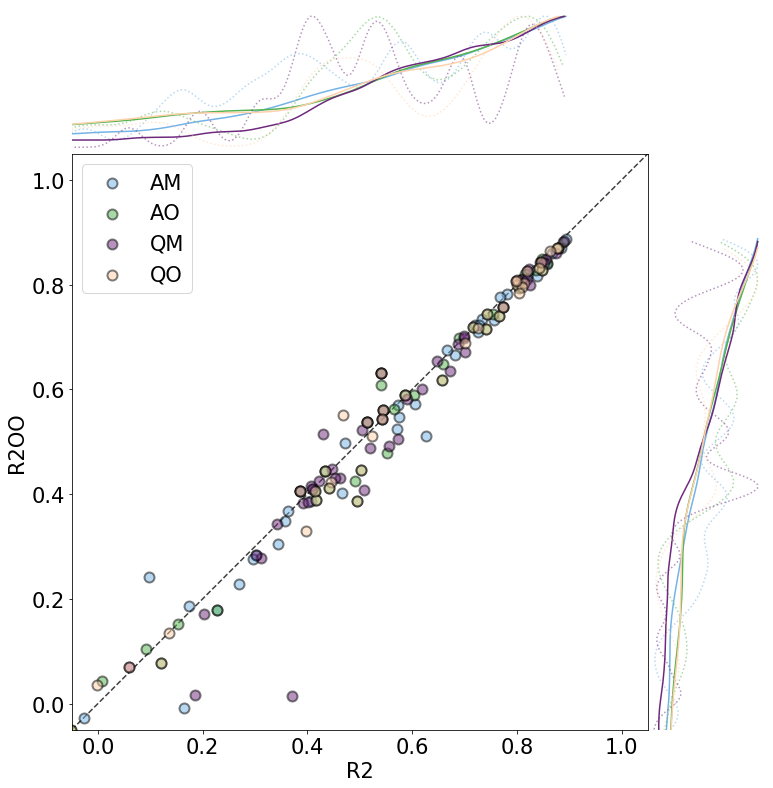

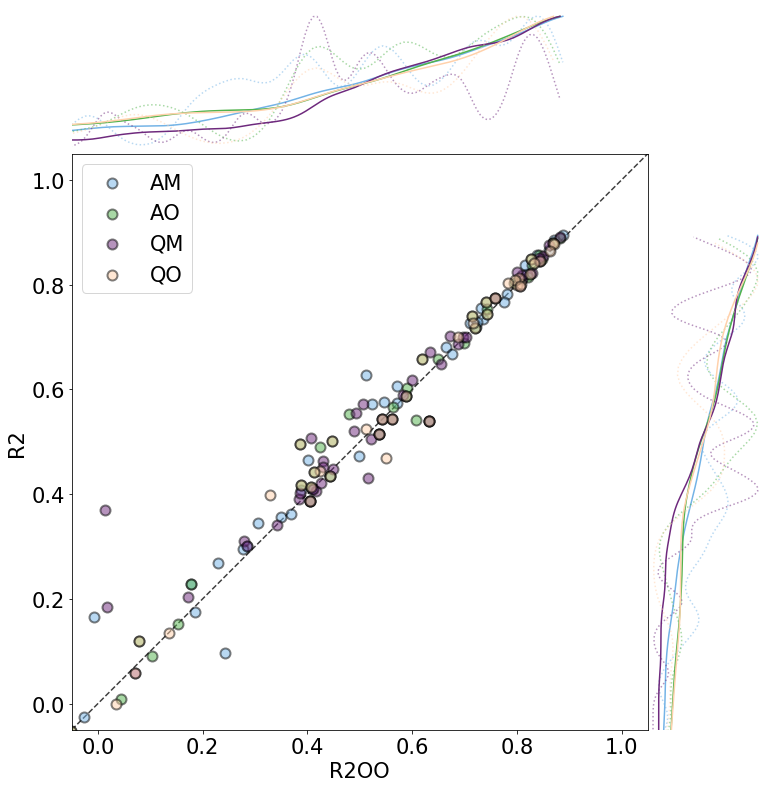

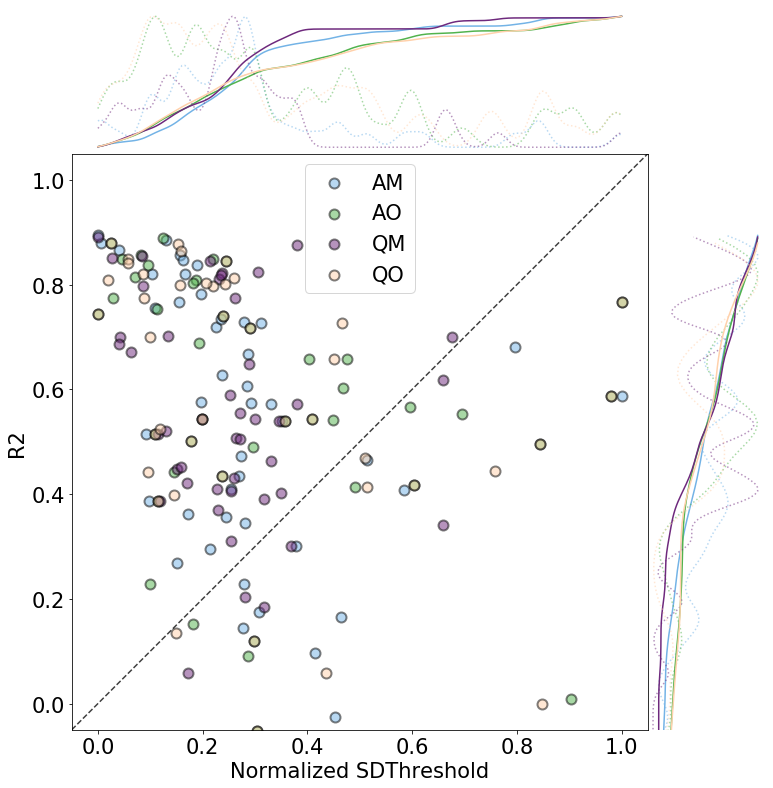

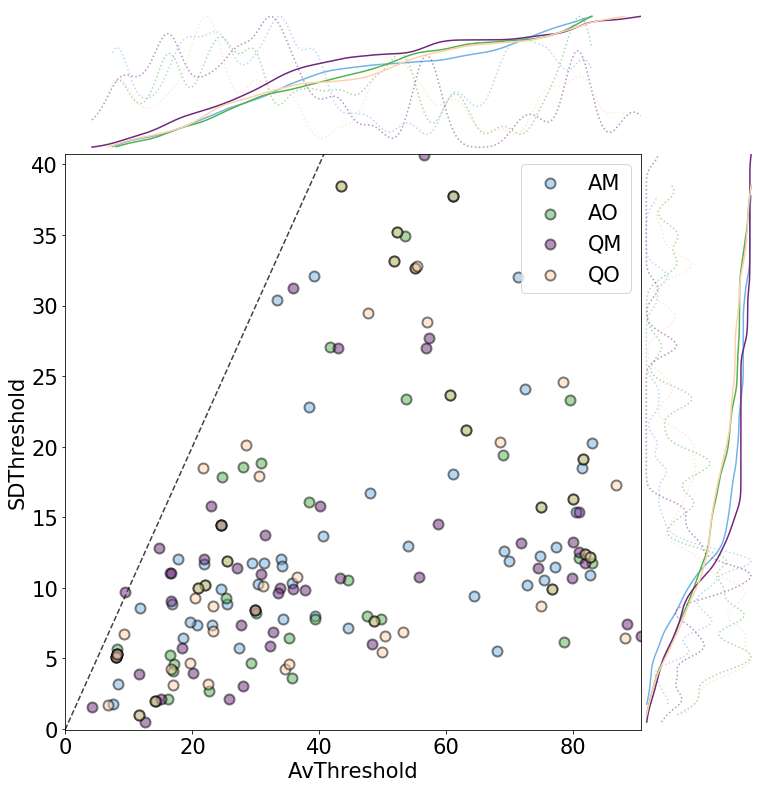

In [271]:
# Distribution Plots for Observer

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



#Normalize vals on 0 to 1 scale
def normalize_vals(x, log = False):
    return ((x - min(x)) / (max(x) - min(x)))

xvar = 'Avg.Res'
yvar = 'R2'


data = {'AM' : (dat_AM, Clr[4]), 'AO': (dat_AO, Clr[3]), 'QM' : (dat_QM, Clr[2]), 'QO' : (dat_QO, Clr[5])}



def do_hist_horiz(ax, x, y, col, bins):
    ax.hist(y, bins = bins,  color=col, rwidth = 0.5, alpha=.6, orientation = 'horizontal',
            normed = True);

def do_hist(ax, x, y, col, bins):
    ax.hist(y, bins = bins, color=col, rwidth = 0.5, alpha=.6, normed = True);

    
def do_hist_horiz_cum(ax, x, y, col, bins):
    ax.hist(y, bins = bins,  color=col, rwidth = 1, alpha=.6, orientation = 'horizontal',
            density = True, histtype='step', cumulative = True);

def do_hist_cum(ax, x, y, col, bins):
    ax.hist(y, bins = bins, color=col, rwidth = 1, alpha=.6, 
            density = True, histtype='step', cumulative = True);
    
def do_scatter(ax, x, y, col, label='R2'):
    ax.scatter(x, y, color=col, edgecolor="k", alpha = 0.5, s=100, linewidths = 2, label = label)

from scipy.stats import gaussian_kde
    
def make_r2_plot(xvar, yvar = 'R2', include_data = data.keys(), norm = False, full_x = False, full_y = False):
    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


    # Top Distribution
    axd = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])

    lims = {'left': -0.05, 'right': 1.05, 'bottom' : -0.05,'top': 1.05}
    
    max_x = 0
    min_x = 0
    max_y = 0
    min_y = 0
    for key, val in data.items():
        if key not in include_data:
            continue
        if full_x:
            mi_x = min(val[0][xvar])
            ma_x = max(val[0][xvar])
            if ma_x > max_x:
                max_x = ma_x
            if mi_x < min_x:
                min_x = mi_x
        if full_y:
            mi_y = min(val[0][yvar])
            ma_y = max(val[0][yvar])
            if ma_y > max_y:
                max_y = ma_y
            if mi_y < min_y:
                min_y = mi_y        
    if full_x:
        lims['left'] = min_x - .05
        lims['right'] = max_x + .05
    if full_y:
        lims['bottom'] = min_y - .05
        lims['top'] = max_y + .05
    
    # Axes properties
    axd.set_xlim(left = lims['left'], right = lims['right']);
    axd.set_axis_off()

    # Right Distribution
    ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])

    # Axes properties
    ax2.set_ylim(bottom = lims['bottom'], top = lims['top']);
    ax2.set_axis_off()

    # Scatter Plot
    ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)

    for key, val in data.items():
        if key not in include_data:
            continue
        x = val[0][xvar]
        y = val[0][yvar]
        
        if norm:
            x = normalize_vals(x)
        
        #do_hist_cum(axd, y, x, val[1], bins = len(y))
        #do_hist_horiz_cum(ax2, x, y, val[1], bins = len(x))
             
        y_sm = np.linspace(min(x), max(x), 200)
        density_x = gaussian_kde(y)
        density_x.covariance_factor = lambda : .08
        density_x._compute_covariance()
        
        x_sm = np.linspace(min(y), max(y), 200)
        density_y = gaussian_kde(x)
        density_y.covariance_factor = lambda : .08
        density_y._compute_covariance()
        
        pdf_x = density_x(x_sm) / max(density_x(x_sm))
        cdf_x = np.cumsum(pdf_x / pdf_x.sum())
        
        pdf_y = density_y(y_sm) / max(density_y(y_sm))
        cdf_y = np.cumsum(pdf_y / pdf_y.sum())
        
        ax2.plot(pdf_x, x_sm, ':', alpha = 0.5, color = val[1])
        axd.plot(y_sm, pdf_y, ':', alpha = 0.5, color = val[1])
        
        ax2.plot(cdf_x, x_sm, color = val[1])
        axd.plot(y_sm, cdf_y, color = val[1])
        
        
        
        do_scatter(ax1, x, y, val[1], label = key)

    #ax1.plot([0,1], [0,1], 'k--', alpha=0.75, zorder=0)
    ax1.plot([lims['left'],lims['right']], [lims['left'],lims['right']], 'k--', alpha=0.75, zorder=0)
    
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)

    # Axes properties
    ax1.set_ylabel(yvar)
    #ax1.text(1.02, 0.52,'Observation day fraction', horizontalalignment='center', transform = ax1.transAxes, 
             #rotation = 'vertical', verticalalignment = 'center')
    
    xlab_pre = ''
    if norm:
        xlab_pre += 'Normalized '
    ax1.set_xlabel('{}{}'.format(xlab_pre,xvar))
    #ax1.text(0.5, 1.01,'Active day fraction', horizontalalignment='center', transform = ax1.transAxes)
    ax1.set_xlim(left = lims['left'], right = lims['right'])
    ax1.set_ylim(bottom = lims['bottom'], top = lims['top']);
    
#make_r2_plot('R2', 'R2DT')
#make_r2_plot('R2DT', 'R2OO')
make_r2_plot('R2', 'R2OO')
make_r2_plot('R2OO', 'R2')
#make_r2_plot('Avg.ResDT', 'R2DT', full_x = True)
make_r2_plot('SDThreshold', 'R2', norm = True)
make_r2_plot('AvThreshold', 'SDThreshold', full_x = True, full_y = True)
#make_r2_plot('AvThreshold', include_data = ['QM', 'QO','AO', 'AM'], norm = True)
